In [1]:
import os
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.feature_selection import mutual_info_regression, f_regression, SelectKBest
from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2
import default_style

font sizes set


In [2]:
DATA_FOLDER = 'dataset'
IMAGE_FOLDER = 'images'
DATASET = os.path.join(DATA_FOLDER, 'outliers_removed.csv')

In [3]:
df = pd.read_csv(DATASET)

df.repetition = df.repetition.apply(str)

numerical_attr_list = [col for col in df.columns if is_numeric_dtype(df[col])]
categorical_attr_list = [col for col in df.columns if not is_numeric_dtype(df[col])]

# one hot encoding
df_reg = df.drop(columns=categorical_attr_list)
# df_reg = df_reg.join(pd.get_dummies(df[categorical_attr_list], columns=categorical_attr_list).astype(int))

df_reg.head()

,frame_count,sum,mean,std,min,max,q01,q05,q25,q75,...,log_lag1_max,log_lag1_q01,log_lag1_q05,log_lag1_q95,log_lag1_q99,log_lag1_kur,log_lag1_kur_w2,log_lag1_kur_w3,log_lag1_min_w4,log_lag1_kur_w4
0,158558,0.145081,9.150000e-07,0.004001,-0.038422,0.040588,-0.012586,-0.005890,-0.000031,0.0,...,-1.737299,-2.791174,-3.285001,-3.285001,-2.767262,1.714222,1.023989,1.340758,-4.214420,0.794669
1,160160,0.114319,7.137790e-07,0.004283,-0.042603,0.048157,-0.013550,-0.006104,-0.000031,0.0,...,-1.965222,-2.759575,-3.260177,-3.260177,-2.737299,1.624565,1.059026,1.472091,-4.214420,0.970269
2,156956,0.149963,9.554485e-07,0.005084,-0.037018,0.058472,-0.015822,-0.007294,0.000000,0.0,...,-1.710629,-2.561207,-3.135239,-3.135239,-2.537726,1.736630,1.113757,1.190945,-4.038329,1.027423
3,152152,0.139618,9.176213e-07,0.004886,-0.036652,0.062683,-0.014923,-0.006714,-0.000031,0.0,...,-1.695906,-2.524224,-3.135239,-3.135239,-2.519815,1.724345,1.085937,1.236662,-4.038329,0.715249
4,169769,0.137665,8.108948e-07,0.002956,-0.026245,0.026215,-0.009399,-0.004364,-0.000031,0.0,...,-2.176993,-2.902666,-3.401507,-3.401507,-2.871997,1.647124,1.113935,1.345926,-4.214420,0.706650


In [4]:
features_to_correct = ['stft_min', 'sc_min']
(df[features_to_correct] < 0).any()

stft_min    False
sc_min      False
dtype: bool

# stft_min

In [5]:
TARGET = 'stft_min'

# drop quantile columns with high percentage of zeros (20%)
zero_percentage = (df_reg == 0).mean()
to_drop = [col for col in df_reg.columns if zero_percentage[col] > 0.2 and re.search(r'q\d{2}', col)]
to_drop.append('sc_min')
df_reg = df_reg.drop(columns=to_drop)
to_drop

['mfcc_q50',
 'sc_q01',
 'sc_q05',
 'stft_q01',
 'stft_q05',
 'mfcc_q25_w1',
 'mfcc_q50_w1',
 'sc_q01_w1',
 'sc_q05_w1',
 'sc_q25_w1',
 'stft_q01_w1',
 'stft_q05_w1',
 'q50_w2',
 'q50_w3',
 'lag1_q50_w3',
 'q75_w4',
 'sc_min']

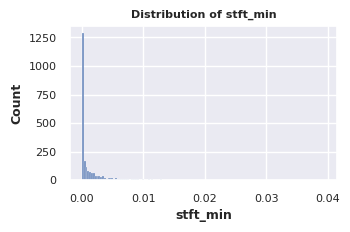

In [6]:
sns.histplot(data=df, x=df[TARGET])
plt.xlabel(f'{TARGET}')
plt.ylabel('Count')
plt.title(f'Distribution of {TARGET}')
plt.savefig(os.path.join(IMAGE_FOLDER, 'initial_stft_min_distr.pdf'), format='pdf')
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

# Take all numerical attributes except for TARGET
df_target_excluded = df_reg[list(set([col for col in df_reg.columns if is_numeric_dtype(df_reg[col])]) - set([TARGET]))]
X = df_target_excluded.values
X = MinMaxScaler().fit_transform(X)
target = df[TARGET].values

# identifies bad rows, the ones han=ving a null TARGET
bad_kids = (target==0)

# Transforms to log scale the good ones
# So bad ones wll be predicted already in log scale
y = target.copy()
y[~bad_kids] = np.log10(y[~bad_kids])

# Defines a train and validation set
train_idxs, val_idxs = train_test_split(np.arange(len(y[~bad_kids])),  test_size=0.2)

print(len(train_idxs), len(val_idxs))

1135 284


invalid literal for int() with base 10: 'd'


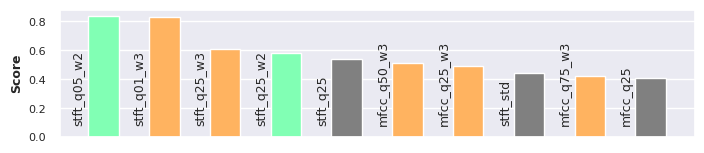

In [20]:
f_selector = SelectKBest(score_func=mutual_info_regression, k='all')
f_selector.fit(X[~bad_kids][train_idxs], y[~bad_kids][train_idxs])

M = 10
best_features = np.flip(np.argsort(f_selector.scores_)[-M:])

# ADD some colors BITCHESSSSS
colors = ["gray"]
colors += sns.color_palette("rainbow", n_colors=3) #["gray", "b", "r", "g", "orange"]
bar_colors = []
for col in df_target_excluded.columns[best_features]:
    try:
        window = col.split("_")[-1]
        window = int(window[-1])        
    except ValueError as e:
        print(e)
        window = 0
    if window <= 3:
        bar_colors.append(colors[window])
    else:
        bar_colors.append(colors[0])

# Do the barplot

plt.figure(figsize=default_style.BAND_FULLSIZE_FIGURE)
plt.bar(range(M), f_selector.scores_[best_features], color=bar_colors, width=0.5)
plt.xticks([])
plt.ylabel('Score')

# Plot the names 
for i, kid in enumerate(best_features):
    if kid < len(df_target_excluded.columns):
        plt.annotate(df_target_excluded.columns[kid], (i-0.4, 0.1), rotation=90, ha="center", fontsize=9)
    else:
        print(f"kid {kid} was over range")

plt.savefig(os.path.join(IMAGE_FOLDER, 'kbest_features_stft_min.pdf'), format='pdf')
plt.show()

In [9]:
f_selector = SelectKBest(score_func=mutual_info_regression, k=M)
f_selector.fit(X[~bad_kids][train_idxs], y[~bad_kids][train_idxs])

X_selected = f_selector.transform(X)

## Now add back the categorical attributes

In [10]:
df_categories = pd.DataFrame()
for cat in categorical_attr_list:
    df_categories[cat] = pd.Categorical(df[cat]).codes
X_cat = df_categories.values

# Join using vstack on transpose
print("selected_num", X_selected.shape)
print("cat", X_cat[~bad_kids].shape)

X_cat_selected = np.vstack((X_selected.T, X_cat.T)).T
print("cat + selected_num", X_cat_selected.shape)

selected_num (2429, 10)
cat (1419, 7)
cat + selected_num (2429, 17)


## XGBoost

In [11]:
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import optuna

# objective function to be minimized
def objective_fun(trial):

    booster = trial.suggest_categorical('booster', ['gbtree', 'dart'])
    gamma = trial.suggest_float('gamma', 0, 5)
    max_depth = trial.suggest_int('max_depth', 3, 20)
    min_child_weight = trial.suggest_int('min_child_weight', 1, 3)
    subsample = trial.suggest_float('subsample', 0.4, 1)
    learning_rate = trial.suggest_float('learning_rate', 1e-3, 1e-1)

    xgb = XGBRegressor(booster=booster, 
                       gamma=gamma, 
                       max_depth=max_depth, 
                       min_child_weight=min_child_weight, 
                       learning_rate=learning_rate,
                       subsample=subsample)

    xgb.fit(X_cat_selected[~bad_kids][train_idxs], y[~bad_kids][train_idxs])
    y_pred = xgb.predict(X_cat_selected[~bad_kids][val_idxs])

    error = r2_score(y_pred, y[~bad_kids][val_idxs])
    return error


study = optuna.create_study(direction="maximize")
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

[I 2023-07-13 00:44:35,219] A new study created in memory with name: no-name-d2bdb75d-ac0d-4307-a591-e0babc6c8b3f
[I 2023-07-13 00:44:36,438] Trial 2 finished with value: 0.880153577498951 and parameters: {'booster': 'gbtree', 'gamma': 0.9798074818285318, 'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.9582579819255779, 'learning_rate': 0.07281115297970724}. Best is trial 2 with value: 0.880153577498951.
[I 2023-07-13 00:44:38,121] Trial 1 finished with value: 0.8449258062813849 and parameters: {'booster': 'gbtree', 'gamma': 3.4998415412463246, 'max_depth': 11, 'min_child_weight': 1, 'subsample': 0.4858728598187205, 'learning_rate': 0.08772355240213739}. Best is trial 2 with value: 0.880153577498951.
[I 2023-07-13 00:44:38,787] Trial 0 finished with value: 0.7918018102476243 and parameters: {'booster': 'gbtree', 'gamma': 4.426340452203102, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.7695467098159298, 'learning_rate': 0.03361374402468081}. Best is trial 2 with value: 0.

[I 2023-07-13 00:44:56,657] Trial 27 finished with value: 0.8781907565363128 and parameters: {'booster': 'dart', 'gamma': 1.250469935033999, 'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.9315624770079722, 'learning_rate': 0.06315565167197677}. Best is trial 19 with value: 0.8997850447343829.
[I 2023-07-13 00:44:58,242] Trial 28 finished with value: 0.8749619218689739 and parameters: {'booster': 'dart', 'gamma': 1.5087851416621074, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.9506366246865317, 'learning_rate': 0.06277084059487356}. Best is trial 19 with value: 0.8997850447343829.
[I 2023-07-13 00:44:59,355] Trial 29 finished with value: 0.8776904997441435 and parameters: {'booster': 'dart', 'gamma': 1.2894798732131303, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.9337744827979966, 'learning_rate': 0.07678735002053605}. Best is trial 19 with value: 0.8997850447343829.
[I 2023-07-13 00:44:59,726] Trial 30 finished with value: 0.8973688580154876 and parameters: {

[I 2023-07-13 00:45:32,404] Trial 55 finished with value: 0.9002176334591754 and parameters: {'booster': 'dart', 'gamma': 0.38293162059821456, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8755052112650977, 'learning_rate': 0.07951746289963718}. Best is trial 47 with value: 0.9016556507853231.
[I 2023-07-13 00:45:33,568] Trial 56 finished with value: 0.9010973872766164 and parameters: {'booster': 'dart', 'gamma': 0.16422762702436125, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8636789911565582, 'learning_rate': 0.09248174050288108}. Best is trial 47 with value: 0.9016556507853231.
[I 2023-07-13 00:45:36,076] Trial 57 finished with value: 0.9003075412118333 and parameters: {'booster': 'dart', 'gamma': 0.1687323667775872, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8715123038640248, 'learning_rate': 0.08046393083024361}. Best is trial 47 with value: 0.9016556507853231.
[I 2023-07-13 00:45:37,255] Trial 58 finished with value: 0.9040551816765456 and paramete

[I 2023-07-13 00:46:11,663] Trial 83 finished with value: 0.9010431888700493 and parameters: {'booster': 'dart', 'gamma': 0.3483982003781421, 'max_depth': 17, 'min_child_weight': 3, 'subsample': 0.890911952921536, 'learning_rate': 0.099659440277994}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:46:13,153] Trial 84 finished with value: 0.8964785774330011 and parameters: {'booster': 'dart', 'gamma': 0.4343002753656046, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.812346780927886, 'learning_rate': 0.09872141017793527}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:46:13,535] Trial 85 finished with value: 0.9001159587826603 and parameters: {'booster': 'dart', 'gamma': 0.2659498633473706, 'max_depth': 20, 'min_child_weight': 3, 'subsample': 0.8882420958223134, 'learning_rate': 0.08641036212738781}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:46:15,543] Trial 86 finished with value: 0.8990870135080744 and parameters: {'

[I 2023-07-13 00:46:46,183] Trial 111 finished with value: 0.898820469635162 and parameters: {'booster': 'gbtree', 'gamma': 0.15109427473774908, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8513671303478899, 'learning_rate': 0.08513028878008103}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:46:48,618] Trial 112 finished with value: 0.8932660619076628 and parameters: {'booster': 'dart', 'gamma': 0.8468726516946103, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.866258314836989, 'learning_rate': 0.0849653004059282}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:46:49,522] Trial 113 finished with value: 0.8903932131264317 and parameters: {'booster': 'dart', 'gamma': 0.8558561742159948, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8662402975331976, 'learning_rate': 0.085106873343536}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:46:51,888] Trial 114 finished with value: 0.8996894386150992 and paramete

[I 2023-07-13 00:47:31,618] Trial 138 finished with value: 0.9007311577231039 and parameters: {'booster': 'dart', 'gamma': 0.13103264499951667, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.8802030321330618, 'learning_rate': 0.09590629313784277}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:47:34,006] Trial 139 finished with value: 0.8999067389009922 and parameters: {'booster': 'dart', 'gamma': 0.3523146087135245, 'max_depth': 19, 'min_child_weight': 3, 'subsample': 0.8769627824860529, 'learning_rate': 0.09676066873558864}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:47:35,536] Trial 140 finished with value: 0.8947821698457679 and parameters: {'booster': 'dart', 'gamma': 0.10487896779160427, 'max_depth': 14, 'min_child_weight': 3, 'subsample': 0.8957363822108192, 'learning_rate': 0.09329241418187967}. Best is trial 66 with value: 0.9045253492683408.
[I 2023-07-13 00:47:35,873] Trial 142 finished with value: 0.8957673112612966 and para

In [12]:
best_params = study.best_params

xgb = XGBRegressor(**best_params)
xgb.fit(X_cat_selected[~bad_kids][train_idxs], y[~bad_kids][train_idxs])

y_pred = xgb.predict(X_cat_selected[~bad_kids][val_idxs])

nrmse = np.sqrt(mean_squared_error(y[~bad_kids][val_idxs], y_pred)) / (np.max(y[~bad_kids][val_idxs]) - np.min(y[~bad_kids][val_idxs]))

print(best_params)
print('Normalized root mean squared error = %.4f' % nrmse)
print('R-squared = %.4f' % r2_score(y[~bad_kids][val_idxs], y_pred))

{'booster': 'dart', 'gamma': 0.2779764603530471, 'max_depth': 12, 'min_child_weight': 3, 'subsample': 0.8533559249884437, 'learning_rate': 0.08580025399210768}
Normalized root mean squared error = 0.0622
R-squared = 0.9167


## Neural Network

In [13]:
from keras.models import Sequential
from keras.layers import Dense

def create_model(params):

#     n_hidden = trial.suggest_int('n_hidden', 2, 5)
#     n_units = trial.suggest_int('n_units', 32, 128)
#     learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1)
    model = Sequential()
    model.add(Dense(X_cat_selected.shape[1], activation='linear'))

    for i in range(params["n_hidden"]):
        model.add(Dense(params["n_units"], activation='relu'))

    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error',
                  optimizer="adam")
    return model


# objective function to be minimized
def objective_fun(trial):
    
    params = dict(n_units=trial.suggest_int("n_units", 32, 128),
                 n_hidden=trial.suggest_int("n_hidden", 2, 6),
#                  learning_rate=trial.suggest_float("learning_rate", 1e-5, 1e-1)
                 )
    
    model = create_model(params)
    model.fit(X_cat_selected[~bad_kids][train_idxs], y[~bad_kids][train_idxs], 
              epochs=trial.suggest_int("epochs", 10, 50), 
              batch_size=32, 
              validation_data=(X_cat_selected[~bad_kids][val_idxs], y[~bad_kids][val_idxs]), 
              verbose=False)
    y_pred = model.predict(X_cat_selected[~bad_kids][val_idxs], verbose=False)

    error = r2_score(y_pred, y[~bad_kids][val_idxs])
    return error


study = optuna.create_study(direction="maximize")
study.optimize(objective_fun, n_trials=150, n_jobs=-1)

2023-07-13 00:47:51.536539: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 00:47:51.632860: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-13 00:47:51.634075: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-13 00:47:53.313725: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
[I 2023-07-13 00:47:54,866] A new study created in memory with name: no-name-7692bcec-bd0a-4707-b80b-ec4cb901d01c
[I 2023-07-13 00:48:17,972] Trial 0 finished with value: 0.5025323962911226 and parameters: {'n_units': 127, 'n_hidden': 4, 'epochs': 29}. Best is trial 0 with value: 0.502532396

[I 2023-07-13 00:52:43,125] Trial 40 finished with value: 0.7745503089115237 and parameters: {'n_units': 93, 'n_hidden': 5, 'epochs': 32}. Best is trial 2 with value: 0.7899471769032803.
[I 2023-07-13 00:52:49,010] Trial 42 finished with value: 0.7465518208154833 and parameters: {'n_units': 93, 'n_hidden': 2, 'epochs': 47}. Best is trial 2 with value: 0.7899471769032803.
[I 2023-07-13 00:52:51,288] Trial 43 finished with value: 0.7010558396655386 and parameters: {'n_units': 94, 'n_hidden': 5, 'epochs': 33}. Best is trial 2 with value: 0.7899471769032803.
[I 2023-07-13 00:52:52,270] Trial 41 finished with value: 0.7710220899342854 and parameters: {'n_units': 90, 'n_hidden': 5, 'epochs': 47}. Best is trial 2 with value: 0.7899471769032803.
[I 2023-07-13 00:53:09,550] Trial 44 finished with value: 0.7728244245904284 and parameters: {'n_units': 86, 'n_hidden': 5, 'epochs': 39}. Best is trial 2 with value: 0.7899471769032803.
[I 2023-07-13 00:53:15,515] Trial 45 finished with value: 0.73405

[I 2023-07-13 00:57:56,070] Trial 84 finished with value: 0.749617404888437 and parameters: {'n_units': 47, 'n_hidden': 3, 'epochs': 49}. Best is trial 76 with value: 0.7911340154775834.
[I 2023-07-13 00:58:00,526] Trial 85 finished with value: 0.7725847078797309 and parameters: {'n_units': 90, 'n_hidden': 4, 'epochs': 49}. Best is trial 76 with value: 0.7911340154775834.
[I 2023-07-13 00:58:18,261] Trial 86 finished with value: 0.7627185063838544 and parameters: {'n_units': 96, 'n_hidden': 4, 'epochs': 49}. Best is trial 76 with value: 0.7911340154775834.
[I 2023-07-13 00:58:24,201] Trial 87 finished with value: 0.7733560683002937 and parameters: {'n_units': 89, 'n_hidden': 4, 'epochs': 47}. Best is trial 76 with value: 0.7911340154775834.
[I 2023-07-13 00:58:25,251] Trial 88 finished with value: 0.7958965080715968 and parameters: {'n_units': 95, 'n_hidden': 4, 'epochs': 47}. Best is trial 88 with value: 0.7958965080715968.
[I 2023-07-13 00:58:27,220] Trial 89 finished with value: 0.7

[I 2023-07-13 01:02:49,818] Trial 127 finished with value: 0.5942281627228234 and parameters: {'n_units': 127, 'n_hidden': 2, 'epochs': 49}. Best is trial 88 with value: 0.7958965080715968.
[I 2023-07-13 01:02:50,200] Trial 129 finished with value: 0.7464522334501256 and parameters: {'n_units': 126, 'n_hidden': 4, 'epochs': 45}. Best is trial 88 with value: 0.7958965080715968.
[I 2023-07-13 01:03:04,530] Trial 132 finished with value: 0.7432471452776463 and parameters: {'n_units': 126, 'n_hidden': 4, 'epochs': 18}. Best is trial 88 with value: 0.7958965080715968.
[I 2023-07-13 01:03:05,925] Trial 130 finished with value: 0.7691610246426235 and parameters: {'n_units': 91, 'n_hidden': 4, 'epochs': 45}. Best is trial 88 with value: 0.7958965080715968.
[I 2023-07-13 01:03:12,405] Trial 133 finished with value: 0.7335425392302698 and parameters: {'n_units': 80, 'n_hidden': 3, 'epochs': 41}. Best is trial 88 with value: 0.7958965080715968.
[I 2023-07-13 01:03:14,190] Trial 131 finished with 

In [14]:
study.best_params

{'n_units': 104, 'n_hidden': 3, 'epochs': 50}

In [15]:
model = create_model(study.best_params)
model.fit(X_cat_selected[~bad_kids][train_idxs], y[~bad_kids][train_idxs], 
          epochs=30, batch_size=128)

y_pred = model.predict(X_cat_selected[~bad_kids][val_idxs])

nrmse = np.sqrt(mean_squared_error(y[~bad_kids][val_idxs], y_pred)) / (np.max(y[~bad_kids][val_idxs]) - np.min(y[~bad_kids][val_idxs]))

print('Normalized root mean squared error = %.4f' % nrmse)
print('R-squared = %.4f' % r2_score(y[~bad_kids][val_idxs], y_pred))


Epoch 1/30
9/9 [==============================] - 2s 3ms/step - loss: 5.2712
Epoch 2/30
9/9 [==============================] - 0s 4ms/step - loss: 2.0262
Epoch 3/30
9/9 [==============================] - 0s 3ms/step - loss: 1.3258
Epoch 4/30
9/9 [==============================] - 0s 3ms/step - loss: 1.0839
Epoch 5/30
9/9 [==============================] - 0s 4ms/step - loss: 0.8308
Epoch 6/30
9/9 [==============================] - 0s 3ms/step - loss: 0.6509
Epoch 7/30
9/9 [==============================] - 0s 4ms/step - loss: 0.5403
Epoch 8/30
9/9 [==============================] - 0s 3ms/step - loss: 0.4559
Epoch 9/30
9/9 [==============================] - 0s 4ms/step - loss: 0.3658
Epoch 10/30
9/9 [==============================] - 0s 6ms/step - loss: 0.3082
Epoch 11/30
9/9 [==============================] - 0s 5ms/step - loss: 0.2508
Epoch 12/30
9/9 [==============================] - 0s 5ms/step - loss: 0.2251
Epoch 13/30
9/9 [==============================] - 0s 4ms/step - loss: 0.

In [16]:
y_pred = model.predict(X_cat_selected[bad_kids])
# y_pred = np.power(10, y_pred)
y_pred

32/32 [==============================] - 0s 2ms/step


array([[-2.3431544],
       [-2.2102206],
       [-2.3605676],
       ...,
       [-3.7697868],
       [-3.9136631],
       [-3.8850331]], dtype=float32)

In [17]:
from umap import UMAP

reducer = UMAP(n_neighbors=20)
embedding = reducer.fit_transform(X_selected)

/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualenvs/DM2-PeqFRmfa/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/djanloo/.local/share/virtualen

9/9 [==============================] - 0s 2ms/step


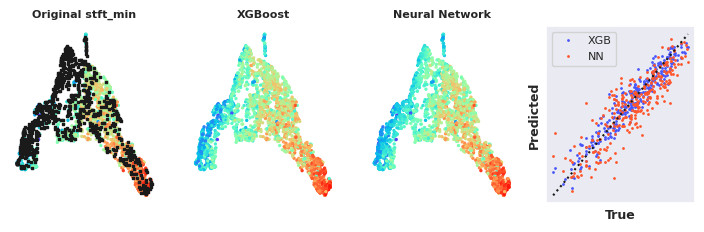

In [18]:
fig, axes = plt.subplots(1,4,figsize=default_style.SHORT_FULLSIZE_FIGURE)

y_correct_xgb = y.copy()
y_correct_xgb[bad_kids] = xgb.predict(X_cat_selected[bad_kids]).squeeze()

y_correct_nn = y.copy()
y_correct_nn[bad_kids] = model.predict(X_cat_selected[bad_kids]).squeeze()


limits = dict(vmin=np.min(y[~bad_kids]), vmax=np.max(y[~bad_kids]), cmap="rainbow")

## NORMAL ## 
axes[0].scatter(*(embedding[~bad_kids].T), s=2, c=y[~bad_kids], **limits)
axes[0].scatter(*(embedding[bad_kids].T), s=1, color="k", marker="s")
axes[0].axis("off");
axes[0].set_title("Original stft_min")


## XGB ##
axes[1].scatter(*(embedding.T), s=2, c=y_correct_xgb, **limits)
axes[1].axis("off");
axes[1].set_title("XGBoost")

## NN ##
axes[2].scatter(*(embedding.T), s=2, c=y_correct_nn, **limits)
axes[2].axis("off");
axes[2].set_title("Neural Network")


#### COMPARISON

y_pred_xgb = xgb.predict(X_cat_selected[~bad_kids][val_idxs])
y_pred_nn = model.predict(X_cat_selected[~bad_kids][val_idxs]).squeeze()

asort = np.argsort(y[~bad_kids][val_idxs])
colors=sns.color_palette("rainbow", n_colors=8)

axes[3].plot(y[~bad_kids][val_idxs][asort], y_pred_xgb[asort], ls="", marker=".", ms=2, label="XGB",color=colors[0])
axes[3].plot(y[~bad_kids][val_idxs][asort], y_pred_nn[asort], ls="", marker=".", ms=2, label="NN",color=colors[-1])

xx = np.linspace(np.min(y[~bad_kids][val_idxs]), np.max(y[~bad_kids][val_idxs]))
axes[3].plot(xx,xx, ls=":", color="k")
axes[3].set_xlabel("True")
axes[3].set_ylabel("Predicted")

axes[3].set_xticks([])
axes[3].set_yticks([])

axes[3].legend()

fig.savefig("images/regession_comparison_stft_min.pdf")